In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as vT
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [38]:
batch_size = 100
n_epochs = 20

input_dim = 32 * 3
hidden_dim = 128
output_dim = 10
n_layers = 3


In [23]:
transforms_train = vT.Compose([
    vT.RandomCrop(32, padding=4),
    vT.RandomHorizontalFlip(),
    vT.ToTensor(),
    vT.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transforms_test = vT.Compose([
    vT.ToTensor(),
    vT.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms_train, download=True)
train_dataset, valid_dataset = random_split(train_dataset, [47000, 3000])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]


Files already downloaded and verified
Files already downloaded and verified


# Visualize CIFAR10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


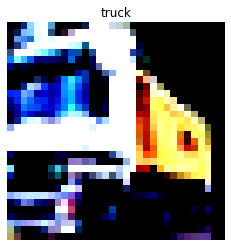

In [5]:
image, label = train_dataset[1]
image = image.numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.title(classes[label])
plt.axis('off')

print(image.shape)


# RNN Model

In [79]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        h0 = h0.to(device)

        out, hn = self.rnn(x, h0)
        out = self.fc(out[-1])

        return out


# LSTM Model

In [78]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        h0, c0 = h0.to(device), c0.to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[-1])

        return out


# GRU Model

In [80]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        h0 = h0.to(device)

        out, hn = self.gru(x, h0)
        out = self.fc(out[-1])

        return out


# coRNN Model

In [117]:
class coRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, dt, gamma, epsilon):
        super().__init__()

        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon

        self.i2h = nn.Linear(input_size + hidden_size + hidden_size, hidden_size)

    def forward(self, x, hy, hz):
        x, hy, hz = x.to(device), hy.to(device), hz.to(device)
        
        combined_layer = torch.cat((x, hz, hy), 1)
        hz += self.dt * (torch.tanh(self.i2h(combined_layer)) - self.gamma * hy - self.epsilon * hz)
        hy += self.dt * hz

        return hy, hz


class coRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dt=0.042, gamma=2.7, epsilon=4.7):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        for l in range(num_layers):
            cornn_cell = coRNNCell(input_size if l == 0 else hidden_size, hidden_size, dt, gamma, epsilon)
            setattr(self, f"cornn_{l}", cornn_cell)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hy = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        hz = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        hy, hz = hy.to(device), hz.to(device)

        for t in range(x.size(0)):
            for l in range(self.num_layers):
                cornn = getattr(self, f"cornn_{l}")

                if l == 0:
                    hy[l], hz[l] = cornn(x[t], hy[l], hz[l])
                else:
                    hy[l], hz[l] = cornn(hy[l-1], hy[l], hz[l])

        out = self.fc(hy[-1])

        return out


In [72]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.permute(0, 2, 1, 3).reshape(batch_size, 32, 96).permute(1, 0, 2)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # ? Forward pass
        # * outputs size = (100, 10)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # ? Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(train_loader)


def validate(model, valid_loader):
    model.eval()
    correct, total = 0, 0

    for images, labels in valid_loader:
        images = images.permute(0, 2, 1, 3).reshape(batch_size, 32, 96).permute(1, 0, 2)
        images = images.to(device)

        outputs = model(images)

        # ? Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()

    accuracy = 100 * correct / total
    
    return accuracy

def predict(model, image):
    image = image.permute(0, 2, 1, 3).reshape(batch_size, 32, 96).permute(1, 0, 2)

    model.eval()
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)

    return predicted


# Training RNN

In [76]:
rnn_model = RNNModel(input_dim, hidden_dim, output_dim)
rnn_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.SGD(rnn_model.parameters(), lr=learning_rate)  
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [77]:
rnn_train_loss = []
rnn_valid_accuracy = []
rnn_test_accuracy = []

for epoch in range(n_epochs):
    loss = train(rnn_model, train_loader, optimizer, criterion)
    rnn_train_loss.append(loss)

    valid_accuracy = validate(rnn_model, valid_loader)
    test_accuracy = validate(rnn_model, valid_loader)
    rnn_valid_accuracy.append(valid_accuracy)
    rnn_test_accuracy.append(test_accuracy)

    print(f"Epoch: {epoch+1}, train loss: {loss:.3f}, valid accuracy: {valid_accuracy:.3f}, test accuracy: {test_accuracy:.3f}")


Epoch: 1, train loss: 2.188, valid accuracy: 18.600, test accuracy: 17.533
Epoch: 2, train loss: 2.155, valid accuracy: 24.367, test accuracy: 23.367
Epoch: 3, train loss: 2.090, valid accuracy: 24.700, test accuracy: 25.133
Epoch: 4, train loss: 2.110, valid accuracy: 22.167, test accuracy: 22.967
Epoch: 5, train loss: 2.121, valid accuracy: 27.000, test accuracy: 26.833
Epoch: 6, train loss: 2.087, valid accuracy: 21.333, test accuracy: 21.067
Epoch: 7, train loss: 2.140, valid accuracy: 21.867, test accuracy: 21.633
Epoch: 8, train loss: 2.136, valid accuracy: 19.967, test accuracy: 20.267
Epoch: 9, train loss: 2.110, valid accuracy: 23.600, test accuracy: 22.867
Epoch: 10, train loss: 2.149, valid accuracy: 22.767, test accuracy: 22.833
Epoch: 11, train loss: 2.137, valid accuracy: 23.967, test accuracy: 23.700
Epoch: 12, train loss: 2.137, valid accuracy: 19.233, test accuracy: 21.333
Epoch: 13, train loss: 2.135, valid accuracy: 21.867, test accuracy: 21.200
Epoch: 14, train loss

# Training LSTM

In [81]:
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)  


In [82]:
lstm_train_loss = []
lstm_valid_accuracy = []
lstm_test_accuracy = []

for epoch in range(n_epochs):
    loss = train(lstm_model, train_loader, optimizer, criterion)
    lstm_train_loss.append(loss)

    valid_accuracy = validate(lstm_model, valid_loader)
    test_accuracy = validate(lstm_model, valid_loader)
    lstm_valid_accuracy.append(valid_accuracy)
    lstm_test_accuracy.append(test_accuracy)

    print(f"Epoch: {epoch+1}, train loss: {loss:.3f}, valid accuracy: {valid_accuracy:.3f}, test accuracy: {test_accuracy:.3f}")


Epoch: 1, train loss: 2.275, valid accuracy: 20.300, test accuracy: 20.633
Epoch: 2, train loss: 2.021, valid accuracy: 24.633, test accuracy: 25.400
Epoch: 3, train loss: 1.865, valid accuracy: 31.967, test accuracy: 31.333
Epoch: 4, train loss: 1.766, valid accuracy: 35.967, test accuracy: 35.867
Epoch: 5, train loss: 1.698, valid accuracy: 36.667, test accuracy: 36.300
Epoch: 6, train loss: 1.648, valid accuracy: 38.367, test accuracy: 38.433
Epoch: 7, train loss: 1.597, valid accuracy: 40.433, test accuracy: 40.967
Epoch: 8, train loss: 1.560, valid accuracy: 42.867, test accuracy: 44.633
Epoch: 9, train loss: 1.522, valid accuracy: 46.033, test accuracy: 44.467
Epoch: 10, train loss: 1.485, valid accuracy: 44.800, test accuracy: 45.000
Epoch: 11, train loss: 1.454, valid accuracy: 45.367, test accuracy: 45.900
Epoch: 12, train loss: 1.426, valid accuracy: 47.300, test accuracy: 47.733
Epoch: 13, train loss: 1.402, valid accuracy: 48.500, test accuracy: 48.800
Epoch: 14, train loss

# Training GRU

In [87]:
gru_model = GRUModel(input_dim, hidden_dim, output_dim, n_layers)
gru_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(gru_model.parameters(), lr=learning_rate)


In [89]:
gru_train_loss = []
gru_valid_accuracy = []
gru_test_accuracy = []

for epoch in range(n_epochs):
    loss = train(gru_model, train_loader, optimizer, criterion)
    gru_train_loss.append(loss)

    valid_accuracy = validate(gru_model, valid_loader)
    test_accuracy = validate(gru_model, valid_loader)
    gru_valid_accuracy.append(valid_accuracy)
    gru_test_accuracy.append(test_accuracy)

    print(f"Epoch: {epoch+1}, train loss: {loss:.3f}, valid accuracy: {valid_accuracy:.3f}, test accuracy: {test_accuracy:.3f}")


Epoch: 1, train loss: 2.279, valid accuracy: 17.200, test accuracy: 17.100
Epoch: 2, train loss: 2.272, valid accuracy: 17.567, test accuracy: 17.600
Epoch: 3, train loss: 2.264, valid accuracy: 17.900, test accuracy: 18.867
Epoch: 4, train loss: 2.256, valid accuracy: 18.933, test accuracy: 18.533
Epoch: 5, train loss: 2.248, valid accuracy: 18.867, test accuracy: 19.133
Epoch: 6, train loss: 2.239, valid accuracy: 20.200, test accuracy: 19.767
Epoch: 7, train loss: 2.228, valid accuracy: 20.867, test accuracy: 21.033
Epoch: 8, train loss: 2.216, valid accuracy: 21.467, test accuracy: 21.400
Epoch: 9, train loss: 2.203, valid accuracy: 22.467, test accuracy: 21.100
Epoch: 10, train loss: 2.188, valid accuracy: 21.567, test accuracy: 21.867
Epoch: 11, train loss: 2.174, valid accuracy: 21.100, test accuracy: 21.800
Epoch: 12, train loss: 2.160, valid accuracy: 22.100, test accuracy: 22.467
Epoch: 13, train loss: 2.148, valid accuracy: 22.667, test accuracy: 23.367
Epoch: 14, train loss

# Training coRNN

In [120]:
cornn_model = coRNNModel(input_dim, hidden_dim, output_dim, 1, dt=0.042, gamma=2.7, epsilon=4.7)
cornn_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0021
optimizer = optim.Adam(cornn_model.parameters(), lr=learning_rate)  


In [121]:
cornn_train_loss = []
cornn_valid_accuracy = []
cornn_test_accuracy = []

for epoch in range(n_epochs):
    loss = train(cornn_model, train_loader, optimizer, criterion)
    cornn_train_loss.append(loss)

    valid_accuracy = validate(cornn_model, valid_loader)
    test_accuracy = validate(cornn_model, valid_loader)
    cornn_valid_accuracy.append(valid_accuracy)
    cornn_test_accuracy.append(test_accuracy)

    print(f"Epoch: {epoch+1}, train loss: {loss:.3f}, valid accuracy: {valid_accuracy:.3f}, test accuracy: {test_accuracy:.3f}")


In [91]:
cornn_train_loss = []
cornn_valid_accuracy = []
cornn_test_accuracy = []

for epoch in range(n_epochs):
    loss = train(cornn_model, train_loader, optimizer, criterion)
    cornn_train_loss.append(loss)

    valid_accuracy = validate(cornn_model, valid_loader)
    test_accuracy = validate(cornn_model, valid_loader)
    cornn_valid_accuracy.append(valid_accuracy)
    cornn_test_accuracy.append(test_accuracy)

    print(f"Epoch: {epoch+1}, train loss: {loss:.3f}, valid accuracy: {valid_accuracy:.3f}, test accuracy: {test_accuracy:.3f}")


Epoch: 1, train loss: 1.985, valid accuracy: 30.700, test accuracy: 31.100
Epoch: 2, train loss: 1.824, valid accuracy: 36.433, test accuracy: 35.033
Epoch: 3, train loss: 1.736, valid accuracy: 39.333, test accuracy: 40.033
Epoch: 4, train loss: 1.680, valid accuracy: 41.000, test accuracy: 41.667
Epoch: 5, train loss: 1.638, valid accuracy: 43.100, test accuracy: 43.400
Epoch: 6, train loss: 1.601, valid accuracy: 43.167, test accuracy: 42.533
Epoch: 7, train loss: 1.576, valid accuracy: 44.633, test accuracy: 44.567
Epoch: 8, train loss: 1.546, valid accuracy: 46.033, test accuracy: 45.500
Epoch: 9, train loss: 1.526, valid accuracy: 45.667, test accuracy: 46.900
Epoch: 10, train loss: 1.510, valid accuracy: 47.167, test accuracy: 46.400
Epoch: 11, train loss: 1.490, valid accuracy: 47.900, test accuracy: 47.167
Epoch: 12, train loss: 1.473, valid accuracy: 47.100, test accuracy: 46.667
Epoch: 13, train loss: 1.463, valid accuracy: 47.500, test accuracy: 48.067
Epoch: 14, train loss

# Plots

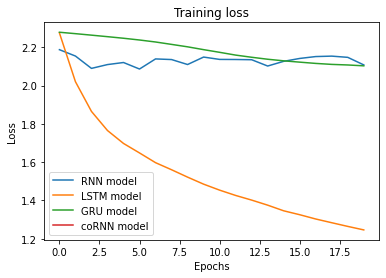

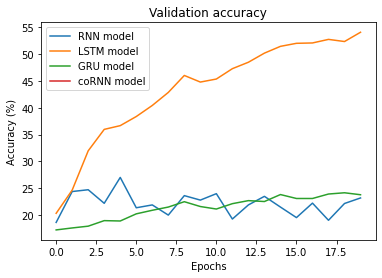

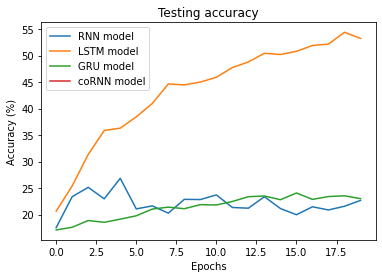

In [98]:
plt.plot(rnn_train_loss, label="RNN model")
plt.plot(lstm_train_loss, label="LSTM model")
plt.plot(gru_train_loss, label="GRU model")
plt.plot(cornn_train_loss, label="coRNN model")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./plots/cifar10/Training loss comparison.png", dpi=300)
plt.show()


plt.plot(rnn_valid_accuracy, label="RNN model")
plt.plot(lstm_valid_accuracy, label="LSTM model")
plt.plot(gru_valid_accuracy, label="GRU model")
plt.plot(cornn_valid_accuracy, label="coRNN model")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("./plots/cifar10/Validation accuracy comparison.png", dpi=300)
plt.show()


plt.plot(rnn_test_accuracy, label="RNN model")
plt.plot(lstm_test_accuracy, label="LSTM model")
plt.plot(gru_test_accuracy, label="GRU model")
plt.plot(cornn_test_accuracy, label="coRNN model")
plt.title("Testing accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("./plots/cifar10/Testing accuracy comparison.png", dpi=300)
plt.show()
